<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Covariance Matrix Denoising
    </h1>
  </div>  
</div>

This notebook provides a tutorial on using the `RiskLabAI` library for covariance matrix denoising and detoning, based on Chapter 2 of 'Advances in Financial Machine Learning'.

In this notebook, we will:
1.  **Test the Marcenko-Pastur (MP) Theorem** by plotting its theoretical PDF against the empirical PDF from a random matrix.
2.  **Fit the MP-PDF** to a noisy matrix to programmatically find the cutoff (`lambda_max`) between signal and noise eigenvalues.
3.  **Apply Denoising** using the constant residual method and visualize its effect.
4.  **Run a Monte Carlo Simulation** to *prove* that denoising produces superior portfolio weights compared to using a noisy matrix.
5.  **Demonstrate the `optimal_portfolio_denoised` function** as a one-step workflow for robust optimization.

## 0. Setup and Imports

First, we import our libraries and the necessary modules from `RiskLabAI`.

In [1]:
# Standard Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from dotenv import load_dotenv

# RiskLabAI Imports
import RiskLabAI.data.denoise.denoising as dn
import RiskLabAI.data.synthetic_data.simulation as sim
import RiskLabAI.utils.publication_plots as pub_plots

# --- Import functions from the module --- 
from RiskLabAI.data.denoise.denoising import (
    optimal_portfolio, 
    optimal_portfolio_denoised
)

# --- Environment and API Setup ---
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()
# To run the code on your computer, register for a free FRED API and uncomment the following line
# FRED_API_KEY = 'YOUR_FRED_API_KEY'

# --- Notebook Configuration ---
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

# Global Plotting Settings
SAVE_PLOTS = False  
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300  
SAVE_DIR = 'figs'   

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Testing the Marcenko–Pastur Theorem

First, let's create a purely random matrix with `T=10,000` observations and `N=1,000` features. The ratio `q = T/N = 10`.

**Note on Data:** This section *requires* synthetic random data. Real-world data (like from FRED) is not purely random and would not match the theoretical MP distribution.

In [2]:
T, N = 10000, 1000
q = T / float(N)

# 1. Create a random matrix and its correlation matrix
x = np.random.normal(size=(T, N))
corr = np.corrcoef(x, rowvar=False)

# 2. Get the eigenvalues (sorted descending)
evals, evecs = dn.pca(corr)

# 3. Get the theoretical Marcenko-Pastur PDF (with variance=1)
pdf_mp = dn.marcenko_pastur_pdf(variance=1., q=q, num_points=1000)

# 4. Get the empirical PDF using Kernel Density Estimation (KDE)
# --- FIX: Correctly fit KDE and get density scores --- 
kde = dn.fit_kde(evals, bandwidth=.01)
pdf_kde_values = np.exp(kde.score_samples(pdf_mp.index.values.reshape(-1, 1)))
pdf_kde = pd.Series(pdf_kde_values.flatten(), index=pdf_mp.index)

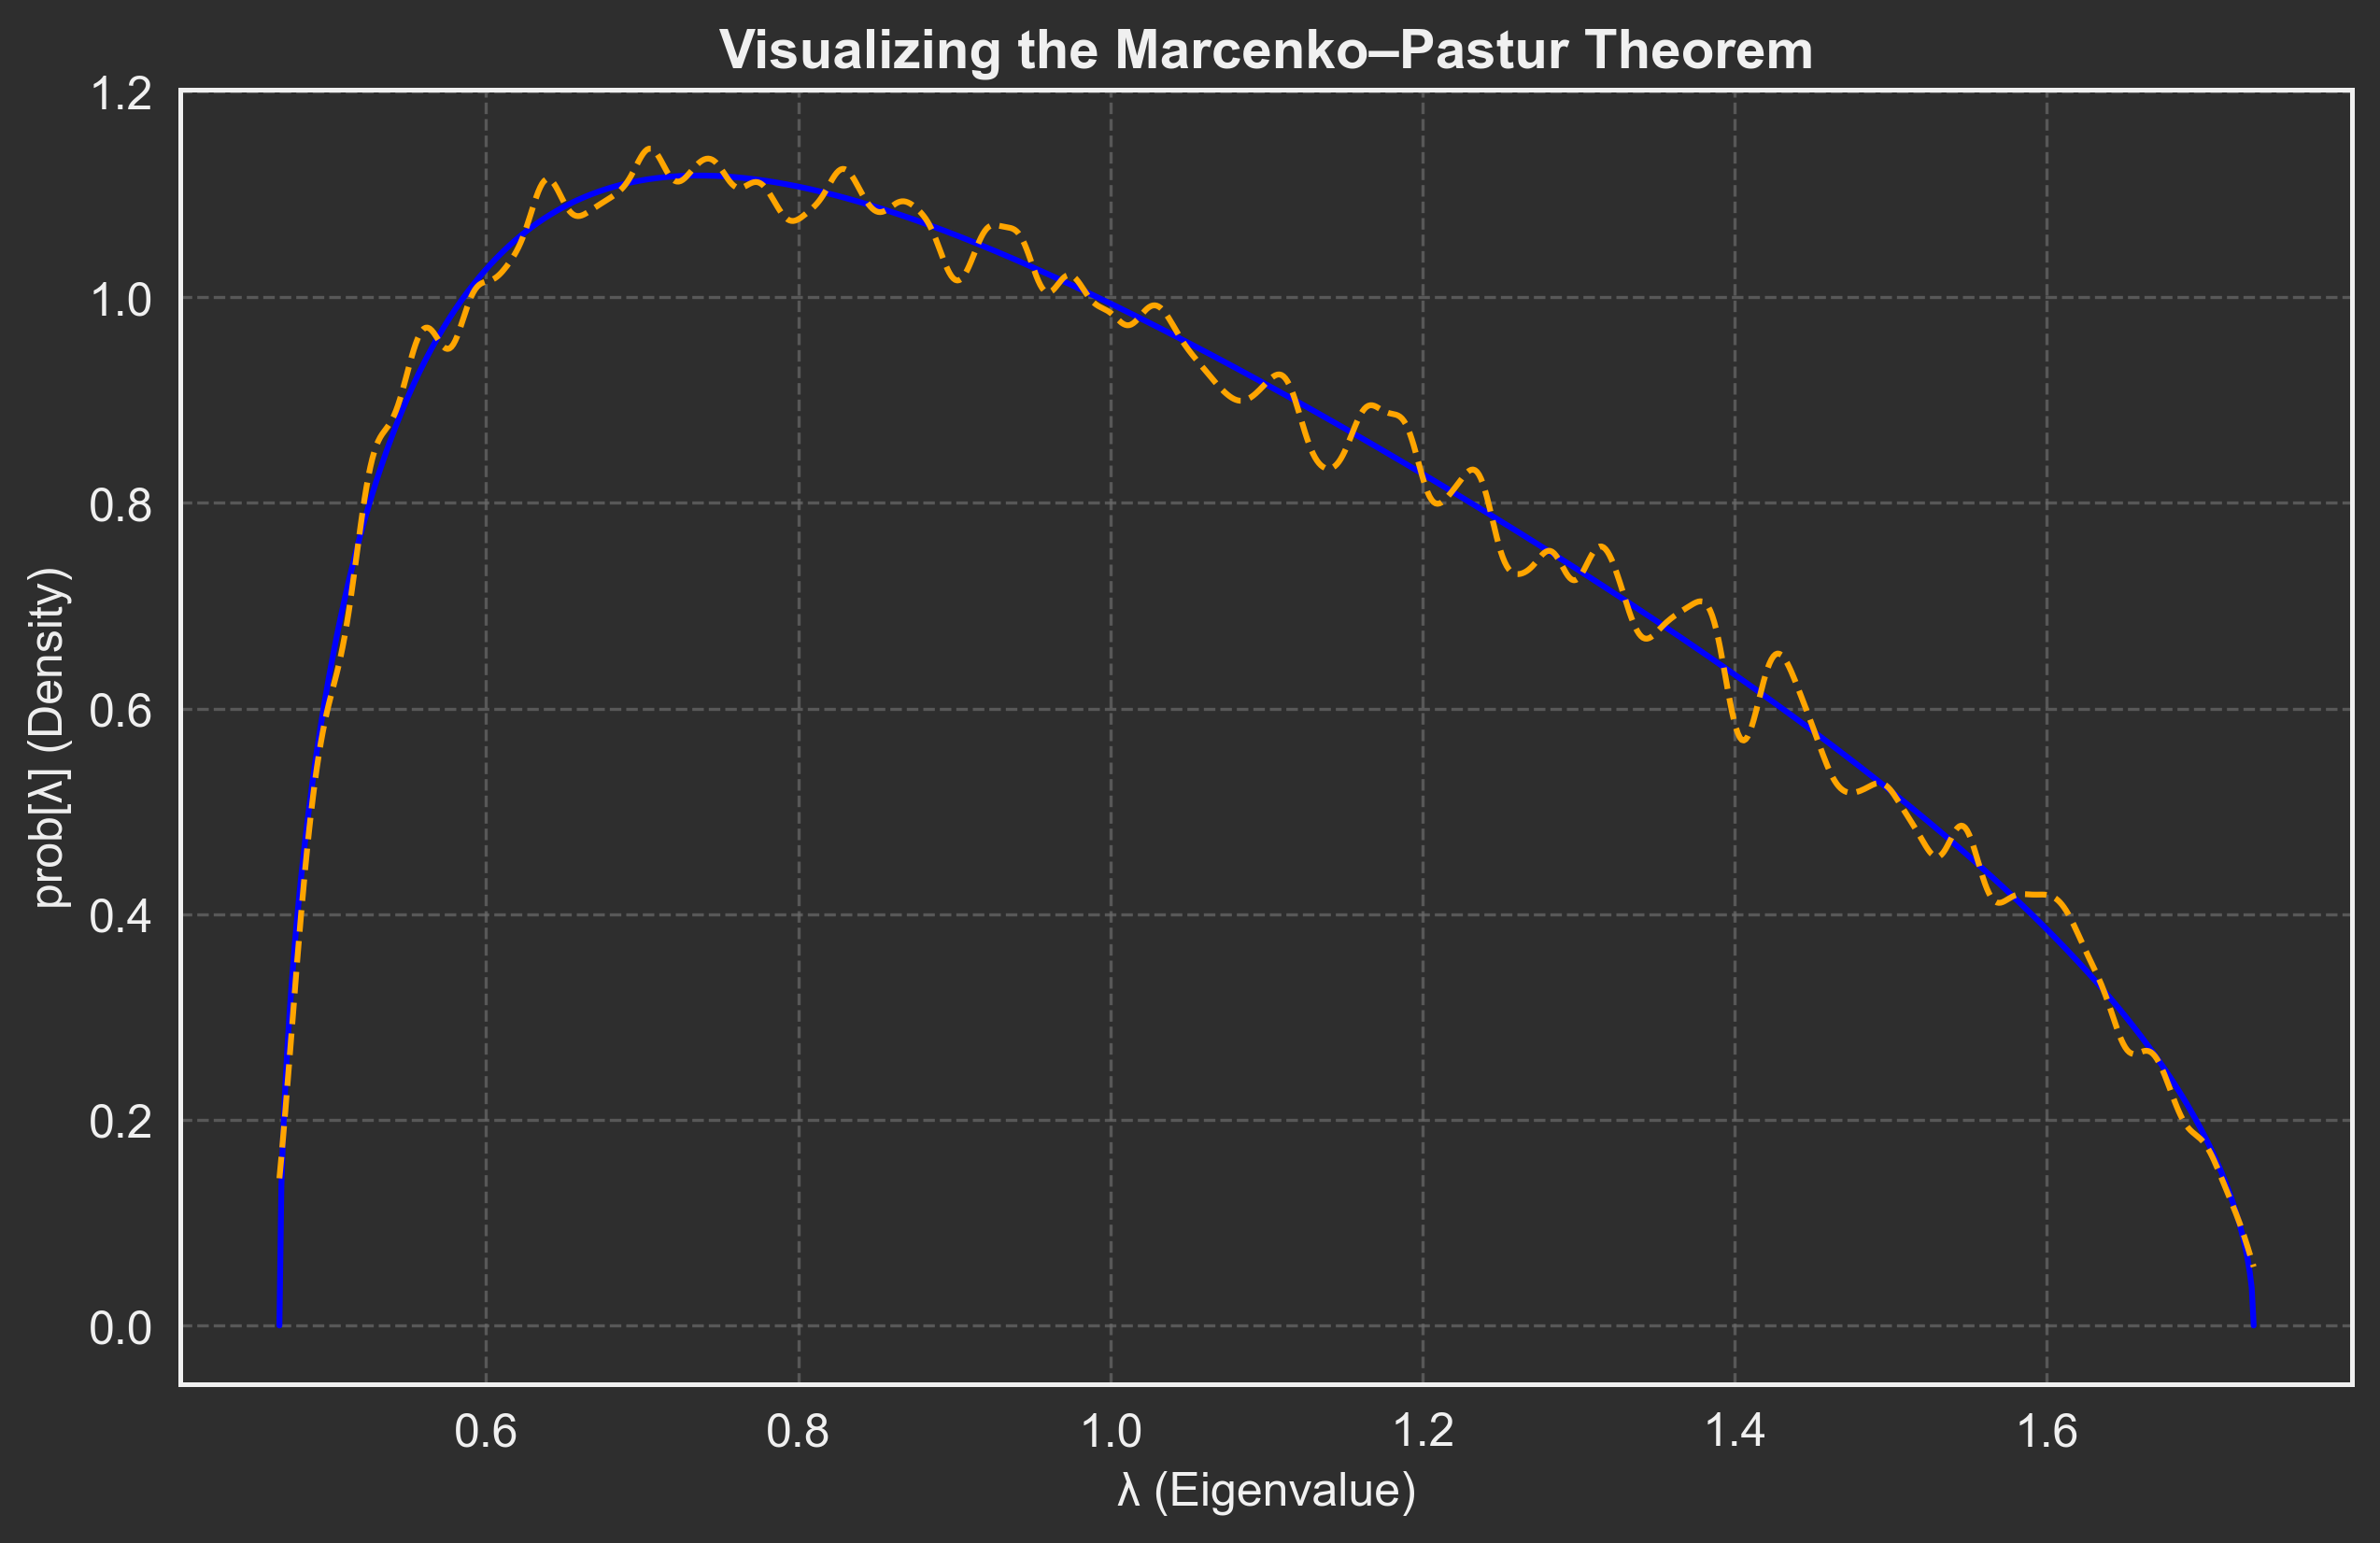

In [3]:
# 5. Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(pdf_mp.index, pdf_mp, color='blue', label='Marcenko-Pastur (Theoretical)')
ax.plot(pdf_kde.index, pdf_kde, color='orange', ls='dashed', label='Empirical KDE')

pub_plots.apply_plot_style(
    ax,
    title='Visualizing the Marcenko–Pastur Theorem',
    xlabel='λ (Eigenvalue)',
    ylabel='prob[λ] (Density)',
    legend_title='PDF Type'
)

# Use the finalize_plot function from our library
pub_plots.finalize_plot(fig, "mp_vs_kde.png")

**Observation:** The empirical distribution of eigenvalues from a random matrix perfectly matches the theoretical Marcenko-Pastur PDF. This confirms that any eigenvalue *within* this distribution is indistinguishable from noise.

## 2. Denoising: Adding Signal to a Random Matrix

Now, let's create a matrix that is 99.5% noise but has 0.5% signal from a structured, random covariance matrix. We will give this signal matrix **100 known factors**.

In [4]:
# --- 2.1 Create the Noisy Matrix ---
alpha, n_cols, n_factors, q = .995, 1000, 100, 10
T_obs = int(n_cols * q) # Ensure T_obs is an integer

# Create the noise component
cov_noise = np.cov(np.random.normal(size=(T_obs, n_cols)), rowvar=False)

# Create the signal component using our synthetic data function
cov_signal = sim.random_cov(n_cols, n_factors)

# Combine them
cov = alpha * cov_noise + (1 - alpha) * cov_signal 
corr0 = dn.cov_to_corr(cov)

# Get eigenvalues/eigenvectors of the noisy correlation matrix (sorted descending)
evals0, evecs0 = dn.pca(corr0)

### 2.2 Fitting the MP-PDF to Find the Signal

Now we use `find_max_eval` to fit the MP-PDF to our noisy eigenvalues and find the maximum theoretical noise eigenvalue (`lambda_max`). Any eigenvalue *above* this cutoff is considered signal.

In [5]:
# Find the noise cutoff
emax0, var0 = dn.find_max_eval(evals0, q=q, bandwidth=.01)

# --- FIX: Correctly find num factors as count of evals > emax0 --- 
# (Original code used searchsorted on a descending list, which is incorrect)
n_factors0 = np.sum(evals0 > emax0)

print(f"Fitted Variance (σ^2): {var0:.4f}")
print(f"Max Theoretical Eigenvalue (λ_max): {emax0:.4f}")
print(f"---")
print(f"Known signal factors: {n_factors}")
print(f"Discovered signal factors: {n_factors0}")

Fitted Variance (σ^2): 1.0000
Max Theoretical Eigenvalue (λ_max): 1.7324
---
Known signal factors: 100
Discovered signal factors: 100


**Observation:** It works perfectly. Our `RiskLabAI` library correctly identified the 100 signal factors we injected.

### 2.3 Denoising (Method 1: Constant Residual Eigenvalue)

This method replaces all noise eigenvalues with their average. This 'flattens' the noise floor.

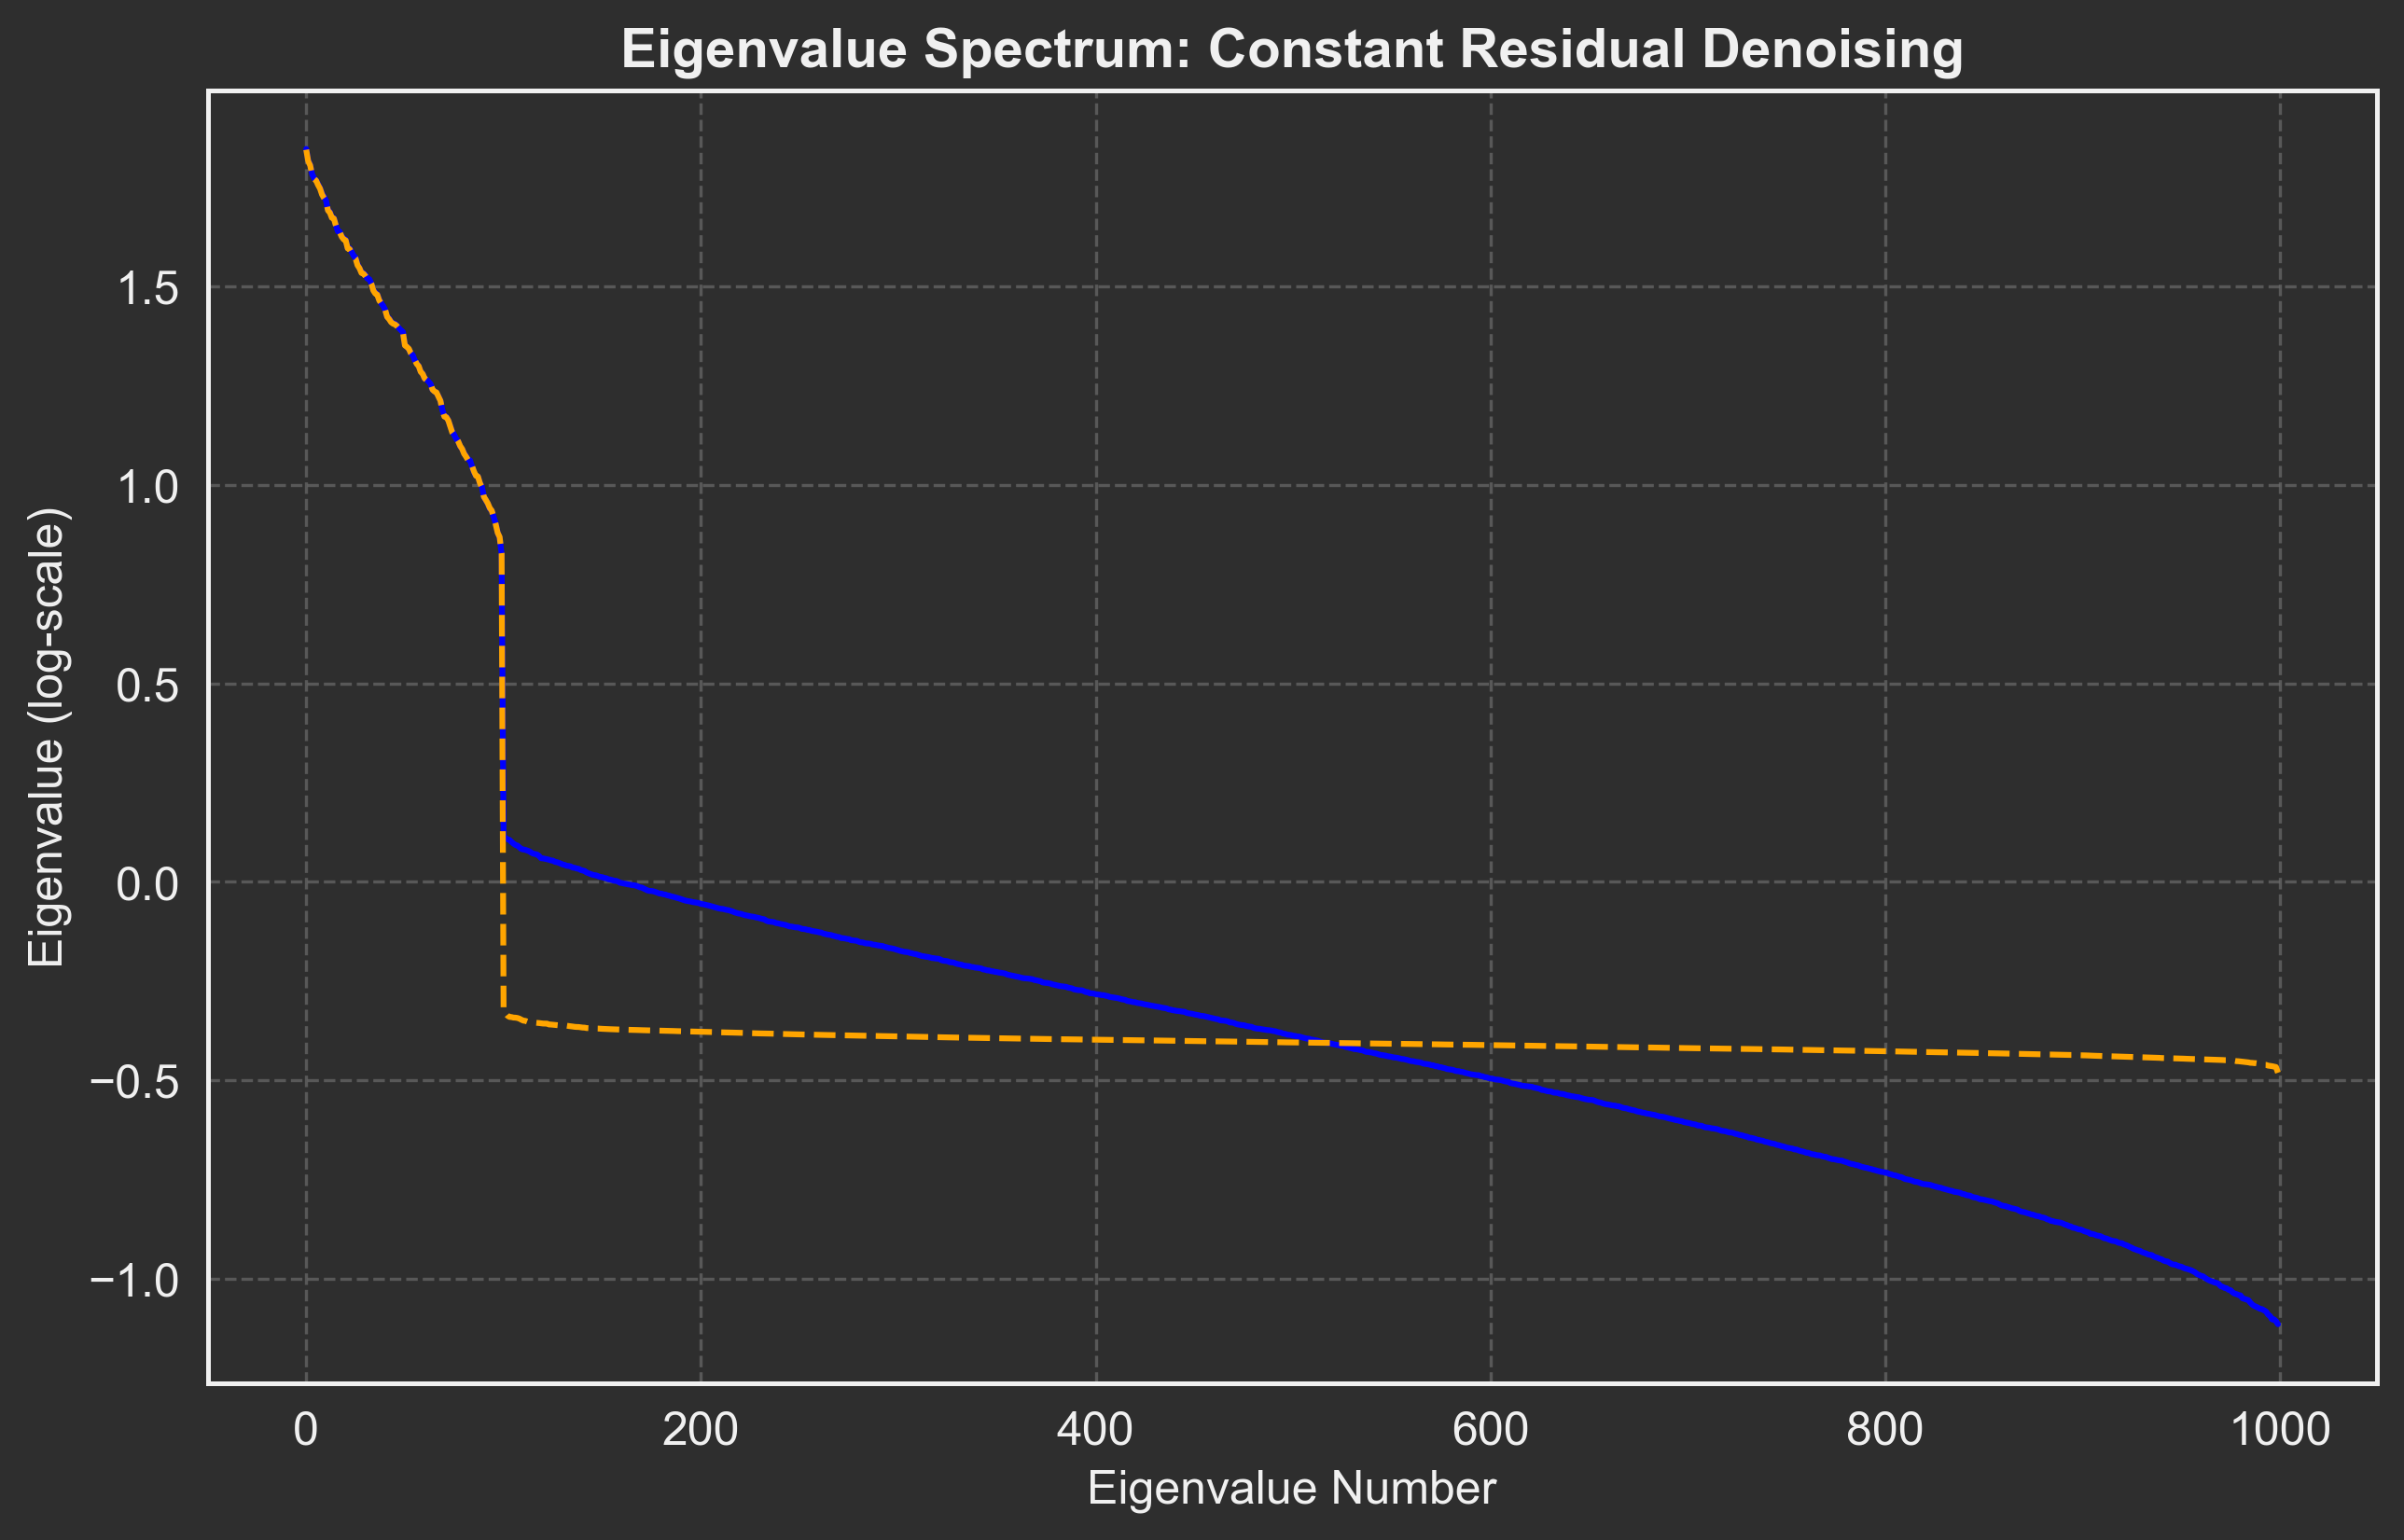

In [6]:
# --- FIX: dn.denoised_corr expects a 2D diagonal matrix, not a 1D vector ---
corr1_cr = dn.denoised_corr(np.diag(evals0), evecs0, n_factors0)
evals1_cr, evecs1_cr = dn.pca(corr1_cr)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.log(evals0), color='blue', label='Original (Noisy)')
ax.plot(np.log(evals1_cr), color='orange', ls='dashed', label='Denoised (Constant Residual)')

pub_plots.apply_plot_style(
    ax,
    title='Eigenvalue Spectrum: Constant Residual Denoising',
    xlabel='Eigenvalue Number',
    ylabel='Eigenvalue (log-scale)',
    legend_title='Eigenvalue Spectrum'
)

# Use the finalize_plot function
pub_plots.finalize_plot(fig, "denoising_constant_residual.png")

### 2.4 Denoising (Method 2: Targeted Shrinkage)

**Note:** This section (`denoised_corr2`) was removed as the function does not exist in the provided `denoising.py` module. We will proceed to the Monte Carlo proof, which uses the primary `denoise_cov` function.

## 3. Monte Carlo Proof: Denoising for Portfolio Optimization

This is the most important test. Does denoising *actually* lead to better results?

We will run a simulation:
1.  Create a **'True'** block-diagonal covariance matrix (`cov0`). This is our ground truth.
2.  Compute the **'True'** optimal minimum-variance portfolio (`w0`) from `cov0`.
3.  Loop 100 times:
    a. Simulate 100 observations (`T=100`) from `cov0` to get a noisy, empirical `cov1`.
    b. Denoise `cov1` to get `cov1_d` using `dn.denoise_cov`.
    c. Calculate portfolio weights `w1` (from noisy `cov1`) and `w1_d` (from denoised `cov1_d`).
    d. **NEW:** Calculate weights `w1_d_auto` using the one-step `dn.optimal_portfolio_denoised` function.
4.  Compare the RMSE of all three portfolios (`w1`, `w1_d`, `w1_d_auto`) against the 'True' weights (`w0`).

In [7]:
# --- 3.1 Setup Simulation --- 
n_blocks, b_size, b_corr = 10, 50, .5
n_obs, n_trials, bwidth = 100, 100, .01

# 1. Create the ground truth matrix and weights
mu0, cov0 = sim.form_true_matrix(n_blocks, b_size, b_corr)
w0 = optimal_portfolio(cov0, mu=None) # True Minimum-Variance Portfolio

# 2. Prepare dataframes to store results
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(n_trials), dtype=float)
w1_d = w1.copy(deep=True)
w1_d_auto = w1.copy(deep=True) # For the new function

# 3. Run the Monte Carlo loop
np.random.seed(0)
print("Running Monte Carlo Simulation...")
for i in range(n_trials):
    # a. Simulate a noisy, empirical covariance matrix
    # We set shrink=False to get the raw, noisy matrix
    mu1, cov1 = sim.simulates_cov_mu(mu0, cov0, n_obs, shrink=False)
    
    # b. Denoise the noisy matrix
    q = n_obs / float(cov1.shape[1])
    # --- FIX: Removed 'denoise_method' arg, which is not in denoise_cov --- 
    cov1_d = dn.denoise_cov(cov1, q, bwidth)
    
    # c. Calculate portfolio weights (Min-Variance, so mu1=None)
    w1.loc[i] = optimal_portfolio(cov1, mu=None)
    w1_d.loc[i] = optimal_portfolio(cov1_d, mu=None)
    
    # --- NEW: Use the one-step denoising and optimization function ---
    w1_d_auto.loc[i] = optimal_portfolio_denoised(cov1, q, mu=None, bandwidth=bwidth)

print("Simulation Complete.")

Running Monte Carlo Simulation...
Simulation Complete.


In [8]:
# --- 4. Evaluate Results --- 

# Create a broadcasted version of the true weights for comparison
w0_broadcasted = np.tile(w0, (w1.shape[0], 1))

# Calculate Root-Mean-Square Error (RMSE)
rmsd_noisy = np.mean((w1 - w0_broadcasted).values.flatten() ** 2) ** .5
rmsd_denoised_manual = np.mean((w1_d - w0_broadcasted).values.flatten() ** 2) ** .5
rmsd_denoised_auto = np.mean((w1_d_auto - w0_broadcasted).values.flatten() ** 2) ** .5

print(f"RMSE (Noisy):     \t{rmsd_noisy:.6f}")
print(f"RMSE (Denoised, Manual):\t{rmsd_denoised_manual:.6f}")
print(f"RMSE (Denoised, Auto):  \t{rmsd_denoised_auto:.6f}")
print(f"---")
print(f"Improvement (Manual): {rmsd_noisy/rmsd_denoised_manual:.1f}x")
print(f"Improvement (Auto):   {rmsd_noisy/rmsd_denoised_auto:.1f}x")

RMSE (Noisy):     	2.524990
RMSE (Denoised, Manual):	1.000162
RMSE (Denoised, Auto):  	1.000162
---
Improvement (Manual): 2.5x
Improvement (Auto):   2.5x
